# Raw Transformer

In [1]:
import torch

import torch.nn as nn

class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

In [2]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

class TransformerEncoder(nn.Module):
    def __init__(self, src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(
            src_vocab_size, embed_dim, max_length, device
        )
        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                ) for i in range(num_layers)
            ]
        )

    def forward(self, x):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, output, output)
        return output

In [3]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_3 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.dropout_3 = nn.Dropout(p=dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output, _ = self.attn(x, x, x, attn_mask=tgt_mask)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(x + attn_output)

        attn_output, _ = self.cross_attn(
            out_1, enc_output, enc_output, attn_mask=src_mask
        )
        attn_output = self.dropout_2(attn_output)
        out_2 = self.layernorm_2(out_1 + attn_output)

        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout_3(ffn_output)
        out_3 = self.layernorm_3(out_2 + ffn_output)
        return out_3

class TransformerDecoder(nn.Module):
    def __init__(self, tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(
            tgt_vocab_size, embed_dim, max_length, device
        )
        self.layers = nn.ModuleList(
            [
                TransformerDecoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                ) for i in range(num_layers)
            ]
        )

    def forward(self, x, enc_output, src_mask, tgt_mask):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, enc_output, src_mask, tgt_mask)
        return output

In [4]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = TransformerEncoder(
            src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
        )
        self.decoder = TransformerDecoder(
            tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
        )
        self.fc = nn.Linear(embed_dim, tgt_vocab_size)

    def generate_mask(self, src, tgt):
        src_seq_len = src.shape[1]
        tgt_seq_len = tgt.shape[1]

        src_mask = torch.zeros(
            (src_seq_len, src_seq_len),
            device=self.device
        ).type(torch.bool)

        tgt_mask = (torch.triu(torch.ones(
            (tgt_seq_len, tgt_seq_len),
            device=self.device
        )) == 1).transpose(0, 1)
        tgt_mask = tgt_mask.float().masked_fill(
            tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        enc_output = self.encoder(src)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

In [5]:
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

model = Transformer(
    src_vocab_size, tgt_vocab_size,
    embed_dim, max_length, num_layers, num_heads, ff_dim
)

src = torch.randint(
    high=src_vocab_size,
    size=(batch_size, max_length),
    dtype=torch.int64
)

tgt = torch.randint(
    high=tgt_vocab_size,
    size=(batch_size, max_length),
    dtype=torch.int64
)

prediction = model(src, tgt)
prediction.shape  # batch_size x max_length x tgt_vocab_size

torch.Size([128, 100, 2000])

# Text Classification

In [6]:
!pip install datasets

In [7]:
from datasets import load_dataset

ds = load_dataset('thainq107/ntc-scv')

c:\Users\USER\anaconda3\envs\AI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import re
import string

def preprocess_text(text):
    # remove URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r"", text)

    # remove HTML Tags
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove punctuation and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    
    return text

In [9]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

# Define a function to yield tokens
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

# Word-based tokenizer
tokenizer = get_tokenizer("basic_english")

# Build vocabulary
vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(ds['train']['preprocessed_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

# Convert torchtext dataset
def prepare_dataset(df):
    # Create iterator for dataset: (sentence, label)
    for row in df:
        sentence = row['preprocessed_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(ds['train'])
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(ds['valid'])
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(ds['test'])
test_dataset = to_map_style_dataset(test_dataset)

In [10]:
from torch.utils.data import DataLoader

seq_length = 100

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence + ([0] * (seq_length - len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels


train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [11]:
import time
import torch

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f}".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axs[0].plot(epochs, train_accs, label="Training")
    axs[0].plot(epochs, eval_accs, label="Evaluation")
    axs[1].plot(epochs, train_losses, label="Training")
    axs[1].plot(epochs, eval_losses, label="Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [12]:
class TransformerEncoderCls(nn.Module):
    def __init__(self, vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.encoder = TransformerEncoder(
            vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.encoder(x)
        output = self.pooling(output.permute(0, 2, 1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [14]:
import os

import torch.optim as optim

ff_dim = 128
dropout = 0.1

model_cls = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_cls = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)
model_cls.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cls.parameters(), lr=0.00005)

num_epochs = 3
save_model = './model'
os.makedirs(save_model, exist_ok=True)
model_name = 'model'

model_cls, metrics = train(
    model_cls, model_name, save_model, optimizer, criterion, train_dataloader,
    valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  235 batches | accuracy    0.517
| epoch   1 |   100/  235 batches | accuracy    0.557
| epoch   1 |   150/  235 batches | accuracy    0.615
| epoch   1 |   200/  235 batches | accuracy    0.686
-----------------------------------------------------------
| End of epoch   1 | Time: 63.14s | Train Accuracy    0.724 | Train Loss    0.659 | Valid Accuracy    0.746 | Valid Loss    0.553
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.756
| epoch   2 |   100/  235 batches | accuracy    0.776
| epoch   2 |   150/  235 batches | accuracy    0.782
| epoch   2 |   200/  235 batches | accuracy    0.793
-----------------------------------------------------------
| End of epoch   2 | Time: 61.68s | Train Accuracy    0.795 | Train Loss    0.483 | Valid Accuracy    0.799 | Valid Loss    0.444
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.807
| epoch   3 | 

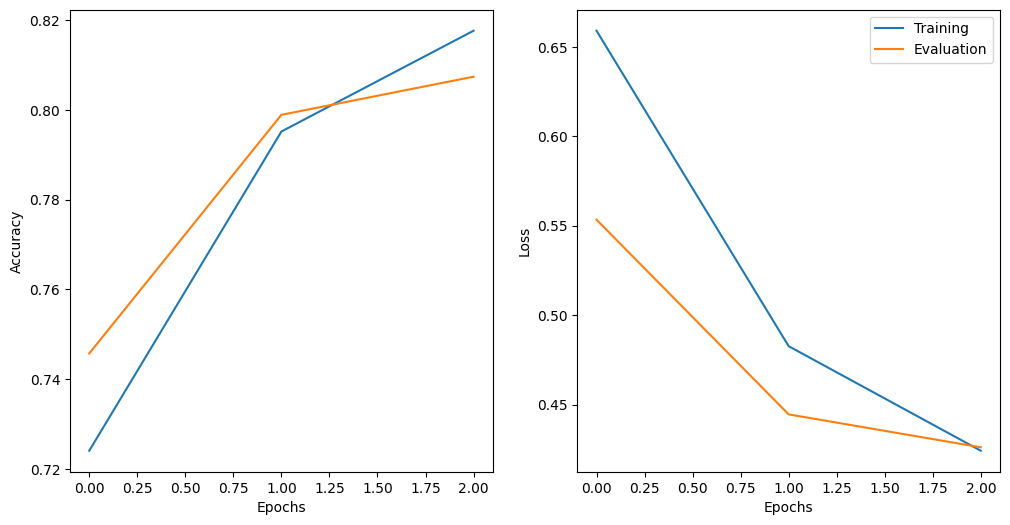

In [15]:
plot_result(num_epochs, metrics['train_accuracy'], metrics['valid_accuracy'], metrics['train_loss'], metrics['valid_loss'])